# Проверка гипотез для увеличения выручки интернет-магазина

## Описание проекта  

Контекст
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

Описание данных
Данные для первой части
Файл /datasets/hypothesis.csv. Скачать датасет
Hypothesis — краткое описание гипотезы;
Reach — охват пользователей по 10-балльной шкале;
Impact — влияние на пользователей по 10-балльной шкале;
Confidence — уверенность в гипотезе по 10-балльной шкале;
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части
Файл /datasets/orders.csv. Скачать датасет
transactionId — идентификатор заказа;
visitorId — идентификатор пользователя, совершившего заказ;
date — дата, когда был совершён заказ;
revenue — выручка заказа;
group — группа A/B-теста, в которую попал заказ.
Файл /datasets/visitors.csv. Скачать датасет
date — дата;
group — группа A/B-теста;
visitors — количество пользователей в указанную дату в указанной группе A/B-теста


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
from scipy import stats as st
import numpy as np
import math as mth

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 130

In [2]:
hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv'))

hypothesis.columns = hypothesis.columns.str.lower()

In [3]:
display(hypothesis.head())
display(orders.head())
display(visitors.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
display(hypothesis.head(50))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# проверим дубликаты
print(hypothesis.duplicated().sum())
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0
0


In [6]:
#проверим общую инфу
print(orders.info())
print()
print(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


In [7]:
# приводим к datetime
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [8]:
# проверим количество групп в тесте
visitors['group'].unique().tolist()

['A', 'B']

In [9]:
#найдем границы проведения тестирования
print('тестирование началось', visitors['date'].min())
print('тестирование закончилось', visitors['date'].max())

тестирование началось 2019-08-01 00:00:00
тестирование закончилось 2019-08-31 00:00:00


In [10]:
# общее число покупателей по группам
orders.groupby('group').agg({'visitorId': 'nunique'}).sum()[0]

1089

In [11]:
# всего покупателей
orders['visitorId'].nunique()

1031

Тут мы видим, что некоторые покупатели были участниками сразу 2х групп

In [12]:
# общее количество уникальных пользователей в двух группах
orders.groupby('group').agg({'visitorId' : 'nunique'})

,visitorId
group,
A,503
B,586


In [13]:
# количество уникальных пользователей, которые оказались одновременно в двух группах
no_uniq_visitorId = orders.loc[:, ['visitorId', 'group']].drop_duplicates().drop(columns=['group'])
no_uniq_visitorId.visitorId.duplicated().sum()

58

In [14]:
visitorsA = orders[orders['group']=='A']['visitorId']
visitorsB = orders[orders['group']=='B']['visitorId']

In [15]:
visitors_AB = orders.loc[orders['visitorId'].isin(visitorsA)& orders['visitorId'].isin(visitorsB),'visitorId'].unique()

In [16]:
#До
(orders.groupby('visitorId')['group'].nunique()>1).count()

1031

In [17]:
#После 
orders = orders.loc[~orders['visitorId'].isin(visitors_AB)]
(orders.groupby('visitorId')['group'].nunique()>1).count()

973

## Приоритизация гипотез

In [18]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

display(hypothesis.sort_values(by='ICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


### Приоритизация методом RICE

In [19]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

display(hypothesis.sort_values(by='RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Вывод: Когда применили метод RICE порядок наиболее приоритетных гипотиз изменился. Произошло это по причине учёта в формуле охвата пользователей, вместо 8, 0, 7 первые места заняли 7, 2, 0.
Предложим для тестирования гипотезы с индексом 7 и 2:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

## Анализ A/B-теста

### График кумулятивной выручки по группам. 

In [20]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))



        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


In [21]:
print('тестирование началось', visitors['date'].min())
print('тестирование закончилось', visitors['date'].max())


тестирование началось 2019-08-01 00:00:00
тестирование закончилось 2019-08-31 00:00:00


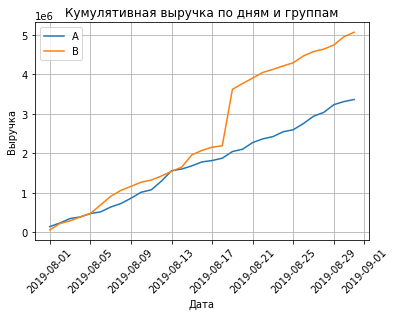

In [22]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend();

Вывод: Вначале месяца выручка в группе B растёт быстрее, чем в A, а 13 августа выручки равняются. Во второй половине месяца выручка группы B делает скачек и продолжает расти. Вероятнее всего на это повлияли крупные заказы или их количество. Возмоджно есть какие-то выбросы, нужно проверить.

### График кумулятивного среднего чека по группам

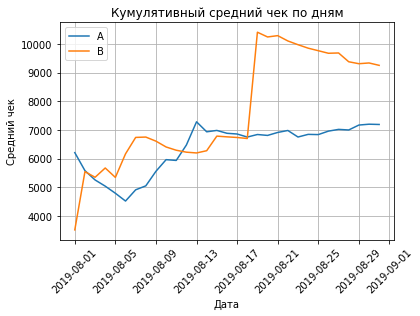

In [23]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек по дням')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend();

Вывод: Кумулятивные значения среднего чека по сегментам продолжают колебаться, ориентировочно 19.08 происходит резкий скачок среднего чека группы В, а затем плавное снижение.

### График относительного изменения кумулятивного среднего чека группы B к группе A.

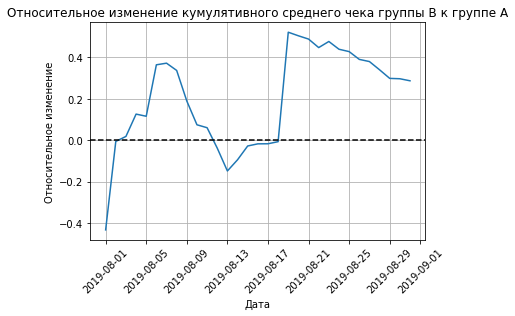

In [24]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.grid()

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45);

Вывод: Видим, резкие изменения у нескольких дат, возможно именно тогда были аномальные заказы. Средний чек "B" рос с 1 августа, 2 августа уже превысил "A". Но с 7 августа началось падение до 13 августа, причем 12-14 августа средний чек "A" был больше "B". Но с 13 числа чек "B" опять начал расти и уже с 15 августа оказался больше и до конца месяца оставался таким. Но опять здесь хорошо видно, что 19 августа был сильный рост и в последующие дни средний чек группы "B" постепенно снижался.

### График кумулятивного среднего количества заказов на посетителя по группам.

In [25]:
# добавим в предыдущие датафреймы посетителей 
# датафрейм с кумулятивным количеством заказов, кумулятивной выручкой и количеством посетителей по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders', 'visitors']]

# датафрейм с кумулятивным количеством заказов, кумулятивной выручкой и количеством посетителей  по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders', 'visitors']]

display(cumulativeRevenueA.head())
print()
display(cumulativeRevenueB.head())

,date,revenue,orders,visitors
0,2019-08-01,142779,23,719
2,2019-08-02,234381,42,1338
4,2019-08-03,346854,66,1845
6,2019-08-04,388030,77,2562
8,2019-08-05,474413,99,3318


,date,revenue,orders,visitors
1,2019-08-01,59758,17,713
3,2019-08-02,221801,40,1294
5,2019-08-03,288850,54,1803
7,2019-08-04,385740,68,2573
9,2019-08-05,475648,89,3280


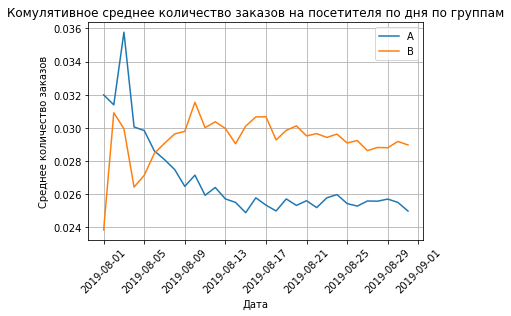

In [26]:
# строим график 
plt.plot(cumulativeRevenueA['date'], (cumulativeRevenueA['orders']/cumulativeRevenueA['visitors']), label='A')
plt.plot(cumulativeRevenueB['date'], (cumulativeRevenueB['orders']/cumulativeRevenueB['visitors']), label='B')

plt.xticks(rotation=45)
plt.title('Комулятивное среднее количество заказов на посетителя по дня по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.grid()
plt.legend();

Вывод: Сначала комулятивное среднее количество заказов на посетителя растёт в обеих группах. Потом начинается резкое падение, которое для группы А продолжается до 9.08, потом более стабильное движение графика. А для группы В начинается комулятивного среднего количества заказов, пик которого приходится на 10.08 с последующим небольшим снижением.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

In [27]:
# собираем предыдущие 2 датафрейма в один
merged_cumulative_revenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date',\
                                                     how='left', suffixes=['A', 'B'])
display(merged_cumulative_revenue.head())



,date,revenueA,ordersA,visitorsA,revenueB,ordersB,visitorsB
0,2019-08-01,142779,23,719,59758,17,713
1,2019-08-02,234381,42,1338,221801,40,1294
2,2019-08-03,346854,66,1845,288850,54,1803
3,2019-08-04,388030,77,2562,385740,68,2573
4,2019-08-05,474413,99,3318,475648,89,3280


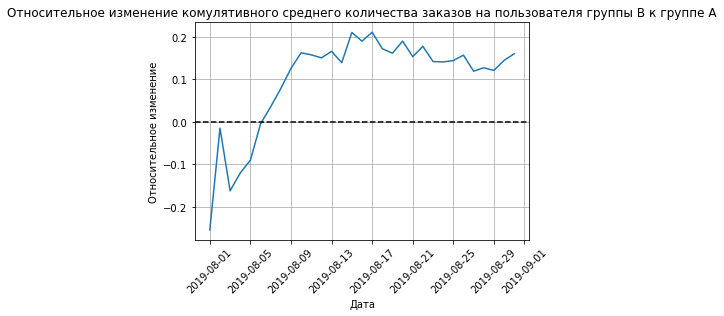

In [28]:
# строим грфик
plt.plot(merged_cumulative_revenue['date'],\
         (merged_cumulative_revenue['ordersB']/merged_cumulative_revenue['visitorsB'])/\
         (merged_cumulative_revenue['ordersA']/merged_cumulative_revenue['visitorsA'])-1)

plt.xticks(rotation=45)
plt.title('Относительное изменение комулятивного среднего количества заказов на пользователя группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.grid()
# добавляем ось Х
plt.axhline(y=0, color='black', linestyle='--');

Вывод: Относительное изменение комулятивного среднего количества заказов на пользователя сначала резко расте для группы В по отношению к группе А, в период со 2.08 по 6.08 наблюдается отрицательные значения, но ориентировочно с 6.08 по 16.08 наблюдается уверенный рост с последующим плавным снижением.

### Точечный график количества заказов по пользователям.

In [29]:
# Подсчитаем количество заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId' : 'nunique',})
    .sort_values(by='transactionId',ascending=False) )
ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.head(10))

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


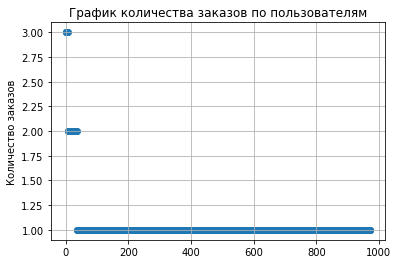

In [30]:
# Построим точечную диаграмму числа заказов на одного пользователя
# сгенерируем номера наблюдений
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.grid()
plt.ylabel('Количество заказов')
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders']);

Вывод: По графикам видно, что большенство пользователей совершают одну покупку, еще некоторая часть 2-4.

### Расчет 95-й и 99-й перцентилей количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

In [31]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

### Точечный график стоимостей заказов.

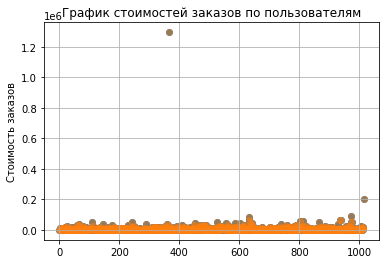

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.grid()
plt.ylabel('Стоимость заказов')
plt.title('График стоимостей заказов по пользователям');
plt.scatter(x_values, orders['revenue'], alpha=0.5); 

In [33]:
# попробуем отфильтровать аномалии и построить график снова
orders_filtered = orders[orders['revenue']<=200000]

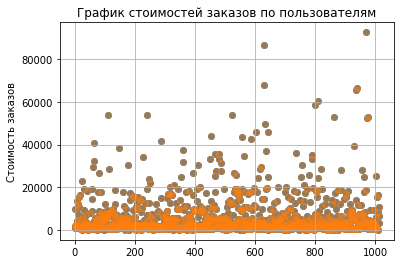

In [34]:
x_values = pd.Series(range(0,len(orders_filtered['revenue'])))
plt.scatter(x_values, orders_filtered['revenue']) 
plt.grid()
plt.ylabel('Стоимость заказов')
plt.title('График стоимостей заказов по пользователям')
plt.scatter(x_values, orders_filtered['revenue'], alpha=0.5);

Вывод: На первом графике с полными данными видим два выброса (заказы стоимостью 200тыс. и более 1.2 млн). Построив график без аномальных значений, видим, что большинство заказов не превышают 60тыс. Посчитаем перцентили, чтобы определиться с точными границами выбросов.

### Расчет 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [35]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Вывод: Только 1% заказов превышают стоимость 53904 руб. Всё, что больше этой стоимости, будем считать выбросами.

### Точечный график стоимостей заказов.

### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов, а тем кто ничего не заказал, будут соответствовать нули.

In [36]:
orders_by_users_A = orders[orders['group']=='A'].groupby('visitorId', as_index=False).\
                                                agg({'transactionId' : pd.Series.nunique})
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = orders[orders['group']=='B'].groupby('visitorId', as_index=False).\
                                                 agg({'transactionId' : pd.Series.nunique})
orders_by_users_B.columns = ['user_id', 'orders']

sample_A = pd.concat([orders_by_users_A['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors']\
                                            .sum() - len(orders_by_users_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors']\
                                            .sum() - len(orders_by_users_B['orders'])), name='orders')],axis=0)




sampleA сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean(). Аналогично найдём среднее группы B: SampleB.mean()

**Сформулируем гипотезы.**  

Нулевая гипотеза H₀: различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет.  

Альтернативная гипотеза H₁: различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть.  

Зададим уровень значимости равным 5%. И воспользуемся критерием Манна-Уитни.

In [37]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sample_B.mean()/sample_A.mean()-1)) 



alpha = 0.05
p-value = 0.011
Относительный показатель 'B' и 'A' = 0.160


Вывод: Получили p-value = 0.011 меньше уровня значимости = 0.05. Значит, отвергаем нулевую гипотезу: различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть. Относительный выигрыш группы "B" над "A" = 16%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

Нулевая гипотеза H₀: различий в среднем чеке заказа между группами по «сырым» данным нет.  
    

Альтернативная гипотеза H₁: различия в среднем чеке заказа между группами по «сырым» данным есть.  
    


Зададим уровень значимости равным 5%. И воспользуемся критерием Манна-Уитни.

In [38]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                                    orders[orders['group']=='B']['revenue'])[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/ \
                                                            orders[orders['group']=='A']['revenue'].mean()-1))

alpha = 0.05
p-value = 0.829
Относительный показатель 'B' и 'A' = 0.287


Получили p-value = 0.829 > 0.05. Значит, не отвергаем нулевую гипотезу: по «сырым» данным значимых различий в среднем чеке заказа между группами нет. Средний чек группы "B" отличается на 28.7%, различие не является статистически значимым.

### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Приняв ранее за аномальных пользователей тех, кто совершил более 2 заказов, или совершил заказ на сумму свыше 53904, мы уберём по 1% пользователей с наибольшим числом заказов и по 1% - с наибольшей стоимостью.
Сделаем срезы пользователей с числом заказов больше 2 — users_with_many_orders и пользователей, совершивших заказы дороже 53904 — users_with_expensive_orders. Объединим их в таблице abnormal_users, удалим дубликаты, отсортируем по возрастанию. Посчитаем, сколько всего аномальных пользователей.

In [39]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > int(np.percentile(ordersByUsers['orders'],[99]))]['user_id'],
        orders_by_users_B[orders_by_users_B['orders'] > int(np.percentile(ordersByUsers['orders'],[99]))]['user_id'],
    ],
    axis=0,
)
print(users_with_many_orders.head())

58      611059232
211    2108163459
310    2988190573
409    3908431265
416    3967698036
Name: user_id, dtype: int64


In [40]:
users_with_expensive_orders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [99]))]['visitorId']

In [41]:
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head())

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64


In [42]:
# посмотрим количество анамальных пользователей
print("Всего аномальных пользователей" ,len(abnormal_users))

Всего аномальных пользователей 16


Нулевая гипотеза H₀: различий среднем количестве заказов на посетителя между группами по «очищенным» данным нет.   


Альтернативная гипотеза H₁: различия в среднем количестве заказов на посетителя между группами по «очищенным» данным есть.    


Зададим уровень значимости равным 5%. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сначала подготовим выборки количества заказов по пользователям по группам теста, создадим переменные sample_A_filtered и sample_B_filtered, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей.

In [43]:
sample_A_filtered = pd.concat([orders_by_users_A[np.logical_not(orders_by_users_A['user_id']. \
    isin(abnormal_users))]['orders'], pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() \
                                    - len(orders_by_users_A['orders'])),name='orders')],axis=0)

sample_B_filtered = pd.concat([orders_by_users_B[np.logical_not(orders_by_users_B['user_id'].\
    isin(abnormal_users))]['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() \
                                   - len(orders_by_users_B['orders'])), name='orders')],axis=0)



In [44]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

alpha = 0.05
p-value = 0.007
Относительный показатель 'B' и 'A' = 0.189


Вывод: Получили p-value = 0.007 < 0.05. Значит, отвергаем нулевую гипотезу. Есть различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Относительный выигрыш группы "B" над "A" стал выше и равен 18.9%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

Нулевая гипотеза H₀: различий в среднем чеке заказа между группами по «очищенным» данным нет.  


Альтернативная гипотеза H₁: различия в среднем чеке заказа между группами по «очищенным» данным есть.   


Зададим уровень значимости равным 5% и воспользуемся критерием Манна-Уитни.

In [45]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
        orders[np.logical_and(orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])[1]))

print("Относительный показатель 'B' и 'A' = {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.788
Относительный показатель 'B' и 'A' = -0.032


Вывод: Получили p-value = 0.788 > 0.05. Значит, не отвергаем нулевую гипотезу. По «очищенным» данным значимых различий в среднем чеке заказа между группами также нет, как и по «сырым» данным. Но теперь средний чек группы "B" меньше группы "A" на 3.2%. По «очищенным» данным нет статистически значимого различия по среднему чеку, чек не увеличился и не уменьшился.

**Общий вывод:**
    
- по "сырым" и по "очищенным" данным есть статистически значимые различия в среднем количестве заказов для групп "А" и "B".  
Относительный выигрыш группы "B" над "A" равен 18.9% по "очищенным" и 16% по "сырым" данным.  
    
- по "сырым" и по "очищенным" данным статистически значимых различий в средних чеках заказов групп "А" и "B" нет. При этом средний чек группы "B" оказался на 3.2% ниже группы "А" по "очищенным" данным, но по "сырым" данным он был больше на 28.7% из-за аномальных заказов, которые в последствии были отсортированы.  
    
В итоге принимаем решение остановить тестирование и зафиксируем преимущество в группе "B", хотя по среднему чеку группы практически равны.  
    
Выбираем гипотезы:
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
